In [2]:
import pickle
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="0.5"

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns


from itertools import product

import awkward as ak
import pandas as pd
from hyperion.constants import Constants
from olympus.event_generation.mc_record import MCRecord
from olympus.event_generation.photon_source import PhotonSource, PhotonSourceType
from olympus.event_generation.photon_propagation.norm_flow_photons import make_generate_norm_flow_photons, make_nflow_photon_likelihood
from olympus.event_generation.photon_propagation.utils import sources_to_model_input
from olympus.event_generation.detector import make_hex_grid, Detector, make_line, make_triang, make_rhombus
from olympus.event_generation.event_generation import generate_cascade
from olympus.event_generation.lightyield import make_pointlike_cascade_source, make_realistic_cascade_source

from hyperion.utils import (
    make_cascadia_abs_len_func,
)
from hyperion.pmt.pmt import make_calc_wl_acceptance_weight
from hyperion.medium import cascadia_ref_index_func, sca_len_func_antares
from hyperion.constants import Constants

from hyperion.models.photon_arrival_time_nflow.net import (
    make_counts_net_fn,
    make_shape_conditioner_fn,
    sample_shape_model,
    traf_dist_builder,
    eval_log_prob
)

import jax
from jax import jit, random
from jax import numpy as jnp
from jax import value_and_grad
from numba.typed import List

from fennel import Fennel, config

import json
%matplotlib inline
from scipy.integrate import quad

# Simulate Cascades
The notebooks demonstrates how to simulate cascades (EM / hadronic)

## Detector Setup
First, we set up our detector. We want to simulate cascades for a triangular line configuration with 20 modules each.

Text(0, 0.5, 'y [m]')

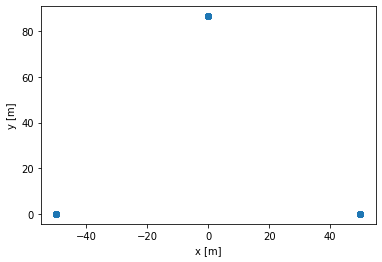

In [7]:
rng = np.random.RandomState(31338)
oms_per_line = 20
dist_z = 50 # m
dark_noise_rate = 16 * 1e-5  # 1/ns
side_len = 100 # m
det = make_triang(side_len, oms_per_line, dist_z, dark_noise_rate, rng)
module_positions = jnp.asarray(det.module_coords)

plt.scatter(module_positions[:, 0], module_positions[:, 1])
plt.xlabel("x [m]")
plt.ylabel("y [m]")





## Propagator Setup
Next, we have to set up our photon propagator. Here we use `make_generate_norm_flow_photons` to create a propagator that samples photon arrival times from a normalizing flow. Every propagator takes the same arguments:
- module coordinates: A numpy array of module coordinates
- module efficiencies (mostly deprecated)
- sources: A list of PhotonSource objects
- c_medium: Speed of light in the medium. This is used to calculate the geometric time and should match what was used in the creatin of the arrival time parametrization.
- seed: An int or jax PRNGKey

In [11]:
gen_ph = make_generate_norm_flow_photons(
    "../../../hyperion/data/photon_arrival_time_nflow_params.pickle",
    "../../../hyperion/data/photon_arrival_time_counts_params.pickle",
   
)

In [ ]:
gen_ph(det.module_coords, det.module_efficiencies)

In [ ]:
event, record = generate_cascade(
    det, event_data["pos"], event_data["t0"], event_dir, energy=event_data["energy"], particle_id=event_data["pid"], pprop_func=gen_ph,
    seed=1, 
    converter_func=make_pointlike_cascade_source,
    pprop_extras={"c_medium": c_medium_f(700) / 1E9}
)

In [ ]:
def c_medium_f(wl):
    """Speed of light in medium for wl (nm)."""
    return Constants.BaseConstants.c_vac / cascadia_ref_index_func(wl)

In [ ]:


ph_lh_func = make_nflow_photon_likelihood(
    "data/photon_arrival_time_nflow_params.pickle",
    "data/photon_arrival_time_counts_params.pickle",
)

event_data = {"t0": 0., "theta": np.radians(30), "phi": np.radians(25), "pos": np.asarray([0, 0, 0.]), "energy": 5E5, "pid": 11}
event_dir = sph_to_cart_jnp(event_data["theta"], event_data["phi"])